In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/output/otto/

test_50.parquet  test_preds.csv		train_20_old.parquet  train_50.parquet
test.parquet	 train_20_old2.parquet	train_20.parquet      train.parquet


# Preprocessing

In [4]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

In [5]:
#test = pd.read_parquet('/content/drive/MyDrive/output/otto/test.parquet')
test = pd.read_parquet('/content/drive/MyDrive/output/otto/test_50.parquet')

In [6]:
def reduce_memory(df):
    df['session'] = df['session'].astype('int32')
    df['aid'] = df['aid'].astype('int32')
    df['session_action_count'] = df['session_action_count'].astype('int16')
    df['session_click_count'] = df['session_click_count'].astype('int16')
    df['session_cart_count'] = df['session_cart_count'].astype('int16')
    df['session_order_count'] = df['session_order_count'].astype('int16')
    df['n_clicks'] = df['n_clicks'].astype('int8')
    df['n_carts'] = df['n_carts'].astype('int8')
    df['n_buys'] = df['n_buys'].astype('int8')
    return df

In [7]:
test = reduce_memory(test)

In [8]:
test.shape

(128682851, 15)

In [9]:
test

,session,aid,score_click,score_cart,score_buy,session_action_count,session_click_count,session_cart_count,session_order_count,n_clicks,n_carts,n_buys,clicks_rank,carts_rank,orders_rank
0,12899779,59625,0.071773,0.071773,0.0,1,1,0,0,-1,-1,-1,601483,-1,-1
1,12899780,582732,0.252664,0.252664,0.0,5,5,0,0,6,4,4,1356,1157,1301
2,12899780,736515,0.711190,0.711190,0.0,5,5,0,0,41,36,33,711,297,459
3,12899780,973453,0.464086,0.464086,0.0,5,5,0,0,-1,-1,-1,9547,13316,-1
4,12899780,1142000,1.071773,1.071773,0.0,5,5,0,0,12,7,6,750,1114,1276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128682846,14571581,145332,NaN,NaN,NaN,0,0,0,0,-1,-1,45,162,62,30
128682847,14571581,1336175,NaN,NaN,NaN,0,0,0,0,-1,-1,46,298,179,31
128682848,14571581,714524,NaN,NaN,NaN,0,0,0,0,-1,-1,47,104,56,32
128682849,14571581,1359971,NaN,NaN,NaN,0,0,0,0,-1,-1,48,110,60,33


In [10]:
DEBUG_MODE = False
if DEBUG_MODE:
    test = test.head(100000)
IGNORE_COL = ['session','aid']

type_list = ['clicks', 'carts', 'orders']

#TYPE_MODE = 'clicks'
#TYPE_MODE = 'carts'
#TYPE_MODE = 'orders'

In [11]:
n_splits = 5

# Read Models

In [12]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

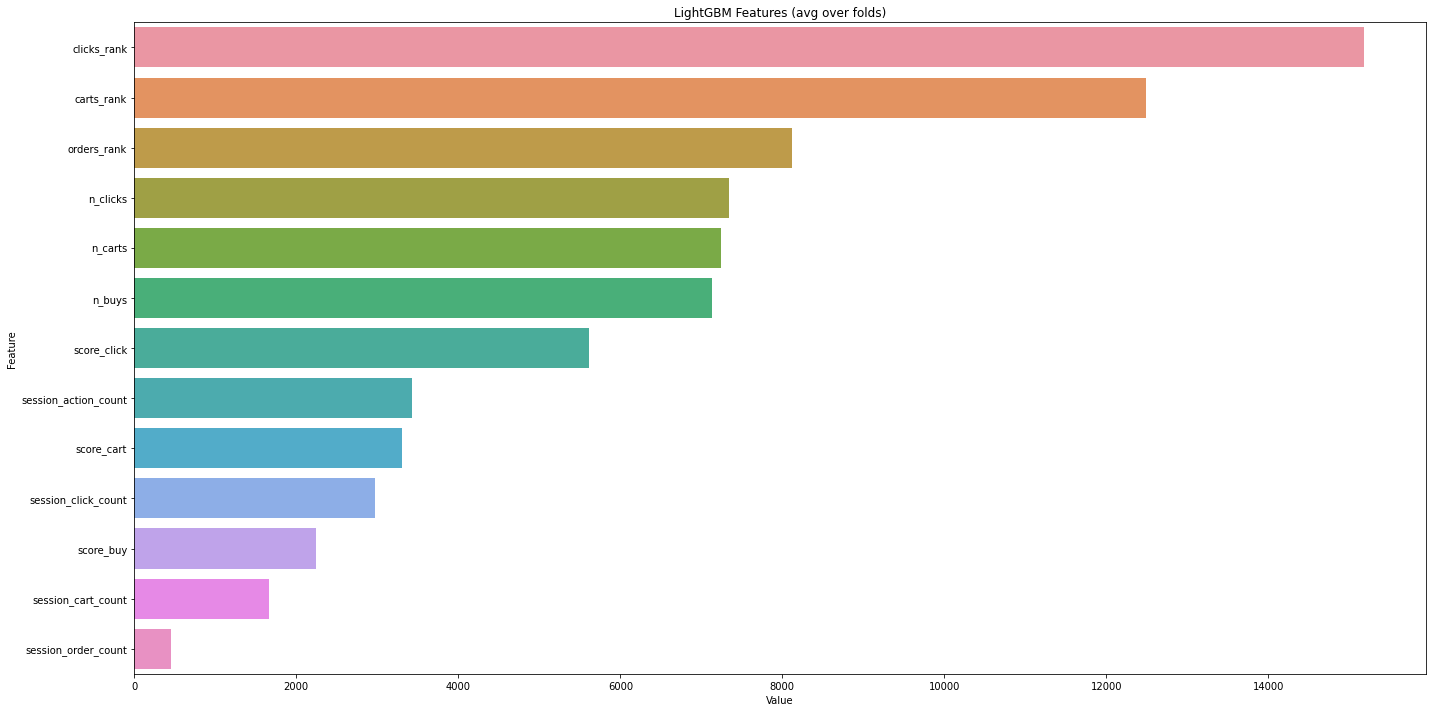

In [13]:
model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold0_clicks.pkl', allow_pickle=True)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [14]:
ans_list = []
# 分割してpredictするための準備
Nrow = test.shape[0]
Ndiv = 5
n = int(Nrow // Ndiv) + 1
x_test = test.drop(IGNORE_COL , axis=1)
x_test_list = []
for i in range(Ndiv):
    tmp = x_test.iloc[i*n : (i+1)*n, :]
    x_test_list.append(tmp)
del x_test
gc.collect()

for target in type_list:
    print('target=', target,'*************')
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))

    # fold looop 
    for fold in range(n_splits):
        print('fold=', fold)
        model = np.load(f'/content/drive/MyDrive/otto/otto_lgbm_fold{fold}_{target}.pkl', allow_pickle=True)

        test_pred_list = [] 
        for i, v in enumerate(x_test_list):
            print('test pred i=', i)
            tmp = model.predict(v)
            test_pred_list.append(tmp) 

        test_pred = np.concatenate(test_pred_list)
        del test_pred_list, model
        gc.collect()

        # testの場合はfoldの数で割る
        test_predictions += test_pred / n_splits

    ans_list.append(test_predictions)
    del test_predictions
    gc.collect()

del x_test_list
gc.collect()

target= clicks *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
target= carts *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 1
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 2
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 3
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
fold= 4
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
target= orders *************
fold= 0
test pred i= 0
test pred i= 1
test pred i= 2
test pred i= 3
test pred i= 4
f

0

In [15]:
ans_list[0]

array([8.00568890e-01, 1.49212282e-01, 1.66256259e-01, ...,
       1.69079748e-04, 2.00026212e-04, 3.01216100e-04])

In [16]:
sub_df_list = []

for i, t in enumerate(type_list):
    print(i, t)
    df = pd.DataFrame(ans_list[i], columns=["score"])
    pred_df = pd.concat([test[['session', 'aid']], df], axis=1)
    pred_df['session_type'] = pred_df['session'].apply(lambda x: str(x) + f'_{t}')
    pred_df = pred_df.sort_values(['session_type','score'],ascending=[True, False]).reset_index(drop=True)

    pred_df['n'] = pred_df.groupby('session_type').cumcount()
    pred_df = pred_df.loc[pred_df.n<20].drop(['n','score','session'],axis=1)
    pred_df['aid'] = pred_df['aid'].astype('int32')
    pred_df = pred_df.groupby('session_type')['aid'].apply(list).reset_index()
    pred_df['labels'] = pred_df['aid'].map(lambda x: ''.join(str(x)[1:-1].split(',')))
    pred_df = pred_df.drop(['aid'],axis=1)
    sub_df_list.append(pred_df)
del df, test
gc.collect()

0 clicks
1 carts
2 orders


0

In [17]:
pred_df = pd.concat([sub_df_list[0], sub_df_list[1], sub_df_list[2]])
del sub_df_list
gc.collect()

0

In [18]:
pred_df.to_csv("/content/drive/MyDrive/output/otto/test_preds.csv", index=False)
pred_df.head()

,session_type,labels
0,12899779_clicks,59625 1253524 438191 737445 731692 94230 17907...
1,12899780_clicks,1142000 736515 582732 973453 487136 889686 150...
2,12899781_clicks,199008 1460571 918667 811084 759436 950718 754...
3,12899782_clicks,834354 889671 479970 552213 987399 1007613 740...
4,12899783_clicks,1817895 607638 169050 1492009 1754419 1216820 ...


In [19]:
pred_df.shape

(5015409, 2)